# Results

This notebook has two different purpose. The first one is to visualize the parameter estimations obtained by both the neural network and the ABC methods. The second one is to assess the effectiveness of the model and check the signals generated by the model with the parameter values estimated for a given subject are a good representation of reality

## Results plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lampe.plots import nice_rc, corner, mark_point, coverage_plot
import torch

import sys
sys.path.append('../')
import FractalModels as fm

# Used for Windows (mixing matplotlib and torch makes the kernal crash)
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Plot methods

In [2]:
def box_plot_three(data_a, data_b, data_c, ticks, width=8, 
                   height=4, labels=['Trial 1', 'Trial 2', 'Trial 3'], 
                   xlabel=r"Estimated value $w^*$", title="", ylabel="Subject", save=""):

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    f = plt.figure()
    f.set_figwidth(width)
    f.set_figheight(height)

    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*3.0-0.6, sym='', widths=0.4, vert=False)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*3.0, sym='', widths=0.4, vert=False)
    bpd = plt.boxplot(data_c, positions=np.array(range(len(data_c)))*3.0+0.6, sym='', widths=0.4, vert=False)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    set_box_color(bpd, '#AD7AB6')

    ticks_str = ticks

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label=labels[0])
    plt.plot([], c='#2C7BB6', label=labels[1])
    plt.plot([], c='#AD7AB6', label=labels[2])
    plt.legend()

    plt.yticks(range(0, len(ticks) * 3, 3), ticks_str)
    plt.ylim(-2, len(ticks)*3)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    if save != "":
        plt.savefig(save)
    plt.show()
    
def box_plot(data_a, ticks, labels, xlabel=r"Estimation $w^*$", width=8, height=5, ylabel="Subject", title="", save=""):

    f = plt.figure()
    f.set_figwidth(width)
    f.set_figheight(height)

    bp = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*3.0, sym='', widths=1, vert=False)
    plt.setp(bp['boxes'], color='#2C7BB6')
    plt.setp(bp['whiskers'], color='#2C7BB6')
    plt.setp(bp['caps'], color='#2C7BB6')
    plt.setp(bp['medians'], color='#D7191C')

    plt.yticks(range(0, len(ticks) * 3, 3), labels)
    plt.ylim(-2, len(ticks)*3)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.tight_layout()
    if save != "":
        plt.savefig(save)
    plt.show()

def box_plot_tests(data_a, data_b, data_c, ticks):

    def set_box_color(bp, color):
        plt.setp(bp['boxes'], color=color)
        plt.setp(bp['whiskers'], color=color)
        plt.setp(bp['caps'], color=color)
        plt.setp(bp['medians'], color=color)

    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(4)

    bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*3.0-0.6, sym='', widths=0.4, vert=False)
    bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*3.0, sym='', widths=0.4, vert=False)
    bpd = plt.boxplot(data_c, positions=np.array(range(len(data_c)))*3.0+0.6, sym='', widths=0.4, vert=False)
    set_box_color(bpl, '#D7191C') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#2C7BB6')
    set_box_color(bpd, '#AD7AB6')

    for i in range(len(ticks)):
        plt.plot([ticks[i], ticks[i]], [i*3-0.8, i*3+0.8], color='black')

    ticks_str = []
    for l in ticks:
        ticks_str.append(str(l))

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#D7191C', label='Trial 1')
    plt.plot([], c='#2C7BB6', label='Trial 2')
    plt.plot([], c='#AD7AB6', label='Trial 3')
    plt.legend()

    plt.yticks(range(0, len(ticks) * 3, 3), ticks_str)
    plt.ylim(-2, len(ticks)*3)
    plt.ylabel(r"Real value of $w$")
    plt.xlabel(r"Estimated value $w^*$")
    plt.tight_layout()
    plt.savefig("TestABC.pdf")
    plt.show()

def bar_plot(data, save = "", bar_labels = ["n", "c", "a"], 
             group_labels = [r"median $w_{SA}^*$", r"median $w_{SS}^*$", r"median $w_{PS}^*$", r"mean $w_{SA}^*$", r"mean $w_{SS}^*$", r"mean $w_{PS}^*$"]):

      
    # Define colors for the bars
    colors = ["royalblue", 'crimson', 'darkorchid', 'deepskyblue', 'orchid']

    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_figwidth(8)

    # Set the positions of the bars
    positions = np.arange(len(group_labels))

    # Set the width and spacing of the bars
    total_bar_width = 0.9  # Total width for each group (including spacing)
    bar_width = total_bar_width / len(bar_labels)  # Width of each individual bar
    bar_spacing = 0  # Spacing between bars within each group

    # Plot each group of bars
    for i in range(len(bar_labels)):
        bar_positions = positions + i * (bar_width + bar_spacing)
        ax.bar(bar_positions, data[:, i], width=bar_width, color=colors[i % len(colors)], edgecolor='black', label=bar_labels[i])

    # Set the x-axis tick positions and labels
    ax.set_xticks(positions + total_bar_width / 2)
    ax.set_xticklabels(group_labels)

    # Display the values above each bar
    for i in range(len(group_labels)):
        for j in range(len(bar_labels)):
            value = data[i, j]
            x_pos = positions[i] + j * (bar_width + bar_spacing)
            ax.text(x_pos, value + 0.001, f'{value:.3f}', ha='center')

    plt.legend()

    if save != "":
        plt.savefig(save)
    # Show the plot
    plt.show()

### ABC results 
The plots show the various parameter estimations obtained with the ABC method

#### Tests
Results of testing the ABC method

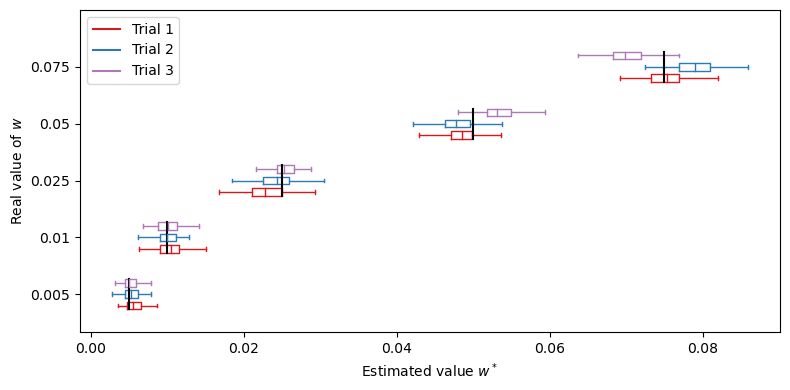

In [3]:
trials1 = np.load('ABC_results/test_trials1.npy').tolist()
trials2 = np.load('ABC_results/test_trials2.npy').tolist()
trials3 = np.load('ABC_results/test_trials3.npy').tolist()
labels = [0.005, 0.01, 0.025, 0.05, 0.075]
box_plot_tests(trials1, trials2, trials3, labels)

#### One subject
Results of one subject

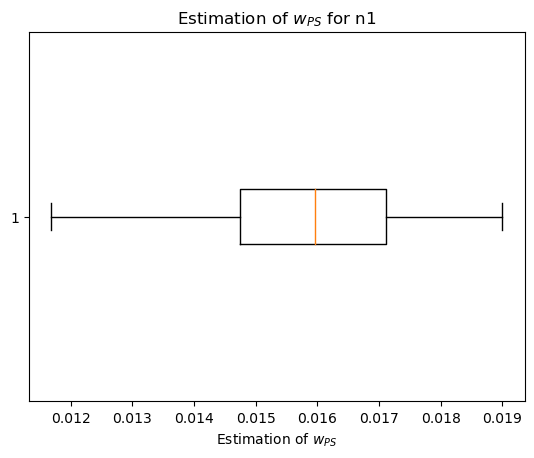

In [137]:
to_load = "ABC_results/"
subject = "n1"
xlabel = r"Estimation of $w$"

trial = np.load(to_load + subject + 'nn.npy')

plt.boxplot(trial, vert=False)
plt.xlabel(xlabel)
plt.title(xlabel + " for " + subject)
plt.show()

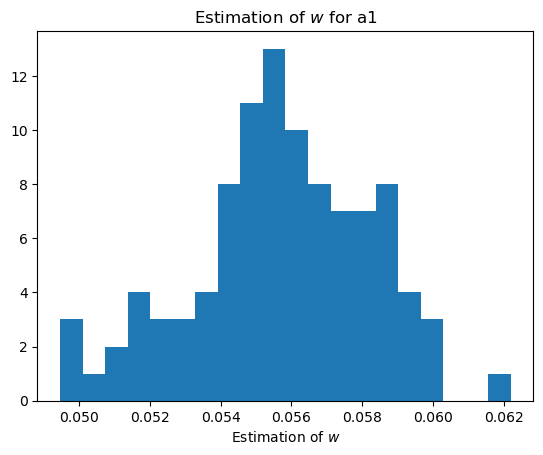

In [144]:
to_load = "ABC_results/"
subject = "a1"
xlabel = r"Estimation of $w$"

trial = np.load(to_load + subject + 'nn.npy')

plt.hist(trial, bins=20)
plt.xlabel(xlabel)
plt.title(xlabel + " for " + subject)
plt.show()

#### All subjects

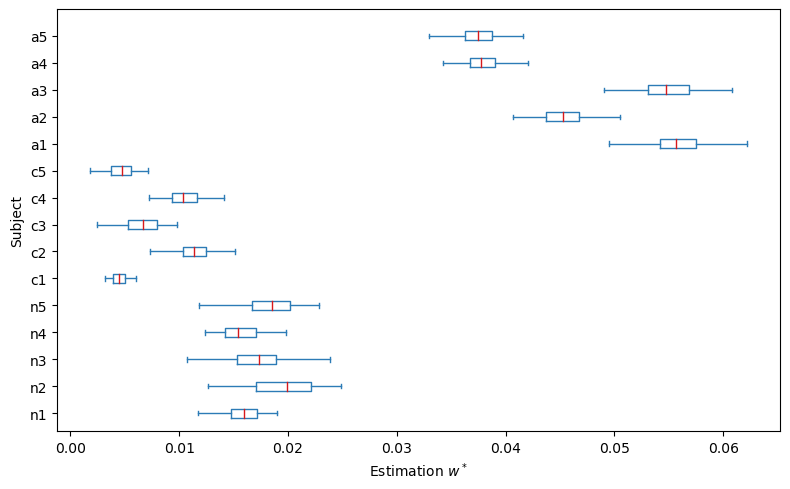

In [146]:
# First trial (with more precision)
data = []
groups = ["n", "c", "a"]
to_load = "ABC_results/"
xlabel = r"Estimation of $w$"

for group in groups:
    for i in range(5):
        trial = np.load(to_load + group + str(i+1) + 'nn.npy')
        data.append(trial)


ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"]
box_plot(data, ticks, labels)

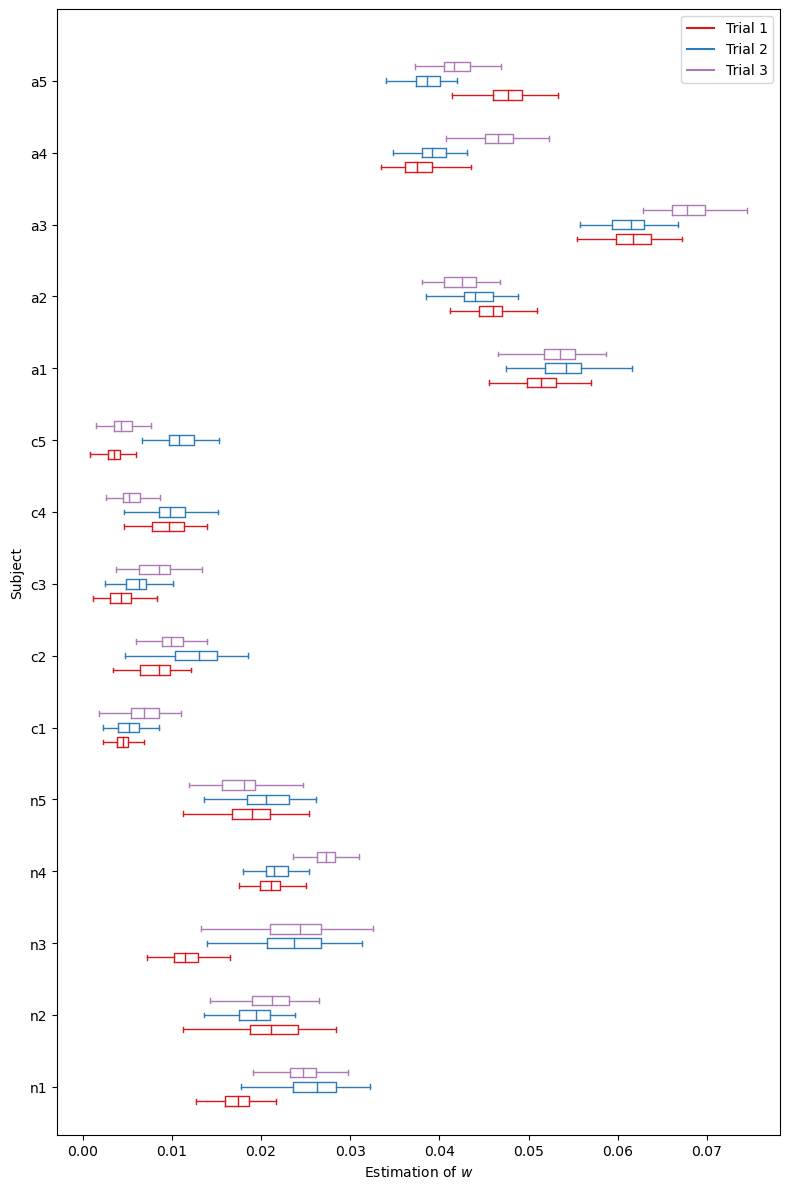

In [3]:
# Second trial (with a bit less precision)
to_load = "ABC_results/"
xlabel = r"Estimation of $w$"

groups = ["n", "c", "a"]
trials1 = []
trials2 = []
trials3 = []

for group in groups:
    for i in range(5):
        trial = np.load(to_load + group + str(i+1) + '.npy')
        trials1.append(trial[0])
        trials2.append(trial[1])
        trials3.append(trial[2])

labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"]

box_plot_three(trials1, trials2, trials3, labels, height=12, xlabel=xlabel, save="ABC_fit_second_trial.pdf")

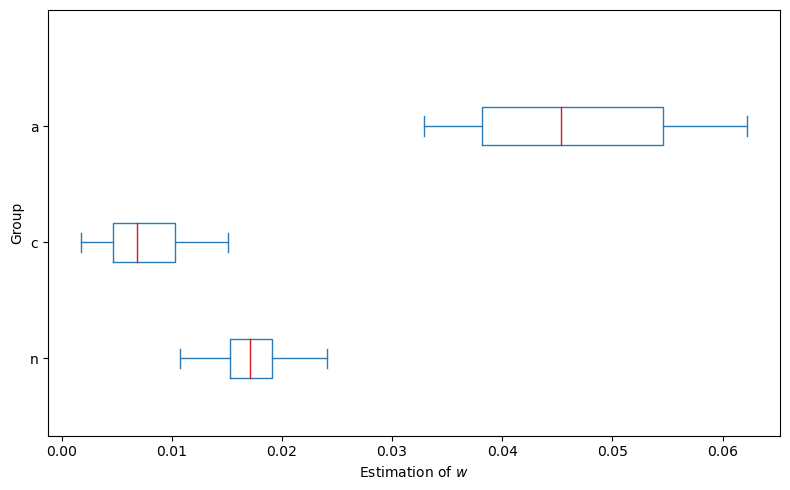

In [4]:
# Estimation per groups (only for the precise trial)
to_load = "ABC_results/"

groups = ["n", "c", "a"]
trials1 = []

for group in groups:
    trial1 = np.load(to_load + group + str(1) + 'nn.npy')
    for i in range(4):
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + 'nn.npy')))
    trials1.append(trial1)

ticks = [1, 2, 3]
box_plot(trials1, ticks, groups, ylabel = "Group", xlabel=xlabel)

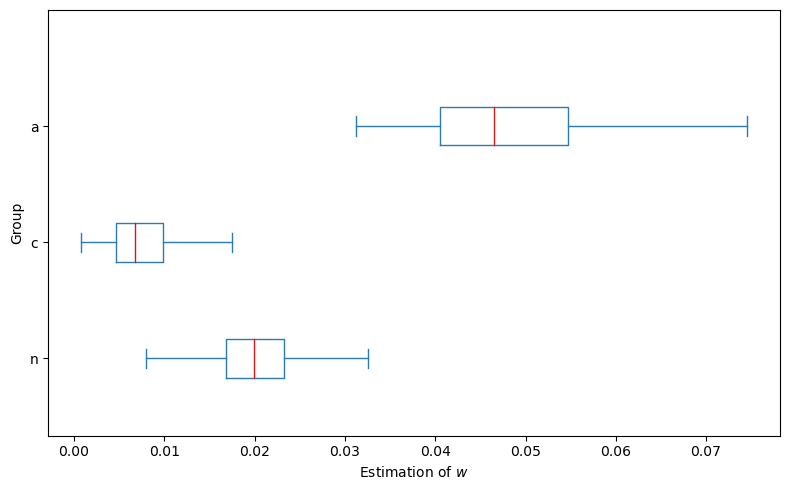

0.020076149189365254 0.004581365723595544
0.00737963477167867 0.0033066631530799134
0.04822884121620861 0.009073202448781811


In [5]:
# Estimation per groups (for all trials)
to_load = "ABC_results/"

groups = ["n", "c", "a"]
trials1 = []

for group in groups:
    trial1 = np.load(to_load + group + str(1) + 'nn.npy')
    tmp = np.load(to_load + group + str(1) + '.npy')
    trial1 = np.concatenate((trial1, tmp[0]))
    trial1 = np.concatenate((trial1, tmp[1]))
    trial1 = np.concatenate((trial1, tmp[2]))
    for i in range(4):
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + 'nn.npy')))
        tmp = np.load(to_load + group + str(i+2) + '.npy')
        trial1 = np.concatenate((trial1, tmp[0]))
        trial1 = np.concatenate((trial1, tmp[1]))
        trial1 = np.concatenate((trial1, tmp[2]))
    trials1.append(trial1)

ticks = [1, 2, 3]
box_plot(trials1, ticks, groups, ylabel = "Group", xlabel=xlabel, save="ABC_fit_groups.pdf")

print(np.mean(trials1[0]), np.std(trials1[0]))
print(np.mean(trials1[1]), np.std(trials1[1]))
print(np.mean(trials1[2]), np.std(trials1[2]))



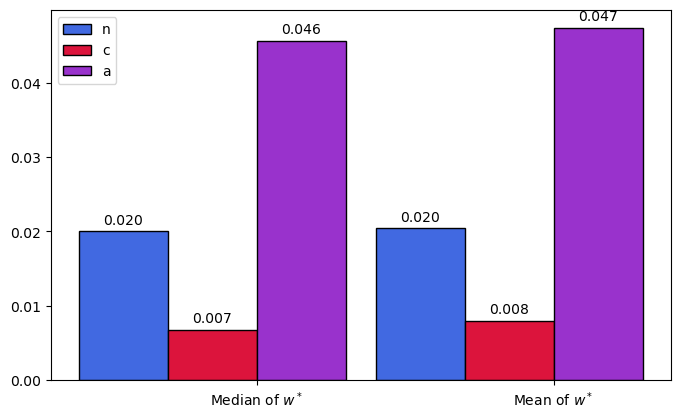

In [153]:
to_load = "ABC_results/"

groups = ["n", "c", "a"]

median = []
mean = []

for group in groups:
    trial1 = np.load(to_load + group + str(1) + 'nn.npy')
    tmp = np.load(to_load + group + str(1) + '.npy')
    trial1 = np.concatenate((trial1, tmp[0]))
    trial1 = np.concatenate((trial1, tmp[1]))
    trial1 = np.concatenate((trial1, tmp[2]))
    for i in range(4):
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + 'nn.npy')))
        tmp = np.load(to_load + group + str(i+2) + '.npy')
        trial1 = np.concatenate((trial1, tmp[0]))
        trial1 = np.concatenate((trial1, tmp[1]))
        trial1 = np.concatenate((trial1, tmp[2]))
    median.append(np.median(trial1))
    mean.append(np.mean(trial1))


data = [np.array(median), np.array(mean)]
bar_plot(np.array(data), group_labels=[r"Median of $w^*$", r"Mean of $w^*$"])


### Neural network
The plots show the various parameter estimations obtained with the neural network

#### One subject

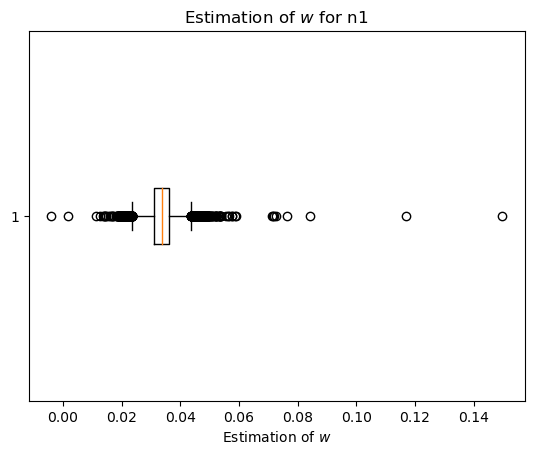

In [132]:
to_load = "NN_results/PS_"
subject = "n1"
xlabel = r"Estimation of $w_{PS}$"

trial = np.load(to_load + subject + '_1.npy')

plt.boxplot(trial, vert=False)
plt.xlabel(xlabel)
plt.title(xlabel + " for " + subject)
plt.show()

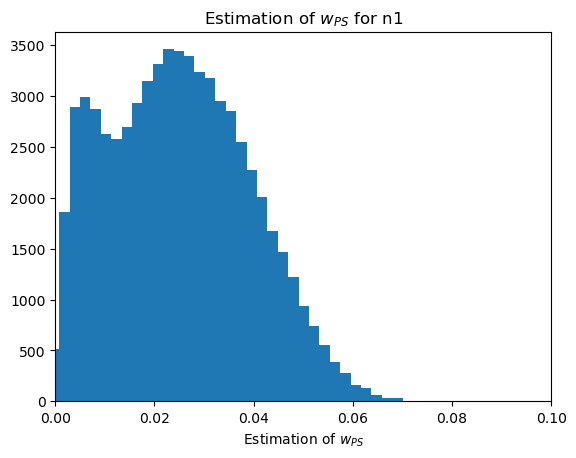

In [44]:
to_load = "NN_results/PS_"
subject = "n1"
xlabel = r"Estimation of $w_{PS}$"

trial = np.load(to_load + group + str(i+1) + '_1.npy')

plt.hist(trial, bins=100)
plt.xlabel(xlabel)
plt.title(xlabel + " for " + subject)
plt.xlim(0, 0.1)
plt.show()

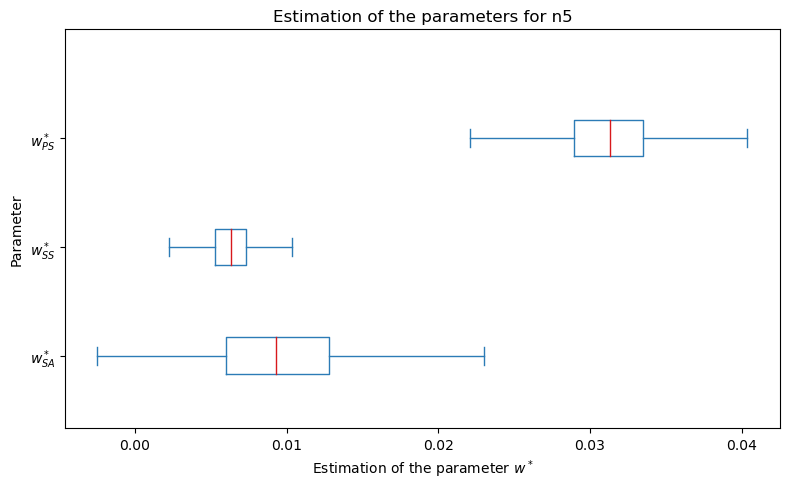

In [26]:
subject = "n5"
xlabel = r"Estimation of the parameter $w^*$"


trials1 = [np.load("NN_results/SA_" + subject + '_1.npy'), np.load("NN_results/SS_" + subject + '_1.npy'), np.load("NN_results/PS_" + subject + '_1.npy')]

ticks = [1, 2, 3]
labels = [r"$w_{SA}^*$", r"$w_{SS}^*$", r"$w_{PS}^*$"]
box_plot(trials1, ticks, labels, ylabel = "Parameter", xlabel=xlabel, title = "Estimation of the parameters for " + subject)

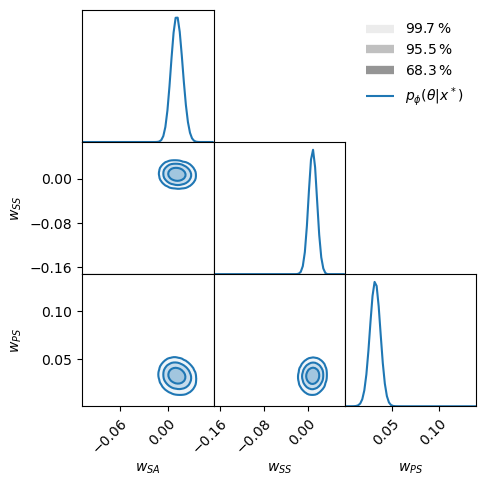

In [29]:
Labels = [r"$w_{SA}$", r"$w_{SS}$", r"$w_{PS}$"]
subject = "n5"

n1 = np.load("NN_results/SA_" + subject + '_1.npy')
n2 = np.load("NN_results/SS_" + subject + '_1.npy')
n3 = np.load("NN_results/PS_" + subject + '_1.npy')


# Convert the NumPy arrays to Torch tensors
torch_tensor_1 = torch.from_numpy(n1)
torch_tensor_2 = torch.from_numpy(n2)
torch_tensor_3 = torch.from_numpy(n3)

# Stack the Torch tensors along the second dimension to create a Torch tensor of size [65536, 3]
torch_vector = torch.stack((torch_tensor_1, torch_tensor_2, torch_tensor_3), dim=1)


fig = corner(
    torch_vector,
    smooth=2,
    labels=Labels,
    legend=r'$p_\phi(\theta | x^*)$',
    figsize=(4.8, 4.8),
)

#### Several subjects

0.03618688


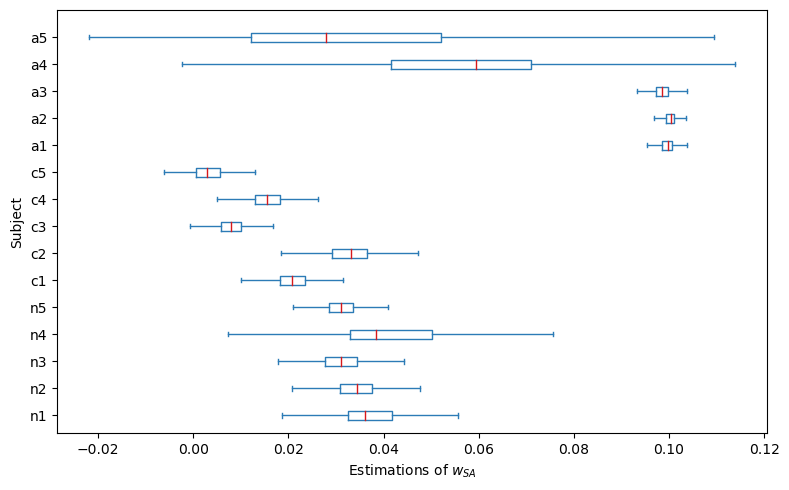

In [46]:
to_load = "NN_results/PS_"
xlabel = r"Estimations of $w_{SA}$"
save_name = "all_subjects_NN_w_sa.pdf"
save_name = ""


groups = ["n", "c", "a"]
trials1 = []

for group in groups:
    for i in range(5):
        trial1 = np.load(to_load + group + str(i+1) + '_1.npy')
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+1) + '_2.npy')))
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+1) + '_3.npy')))
        trials1.append(trial1)

labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"]
ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
box_plot(trials1, ticks, labels, xlabel=xlabel, save=save_name)

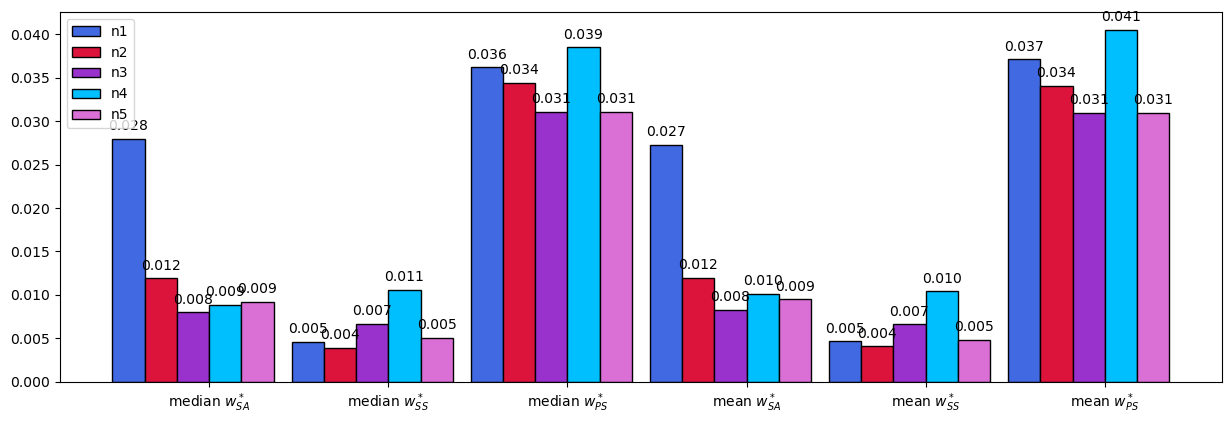

In [123]:
loaders = ["NN_results/SA_", "NN_results/SS_", "NN_results/PS_"]


groups = ["n"]

median_SA = []
median_PS = []
median_SS = []

mean_SA = []
mean_PS = []
mean_SS = []

for to_load in loaders:
    for group in groups:
        for i in range(5):
            trial1 = np.load(to_load + group + str(i+1) + '_1.npy')
            trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+1) + '_2.npy')))
            trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+1) + '_3.npy')))

            if to_load == "NN_results/SA_":
                median_SA.append(np.median(trial1))
                mean_SA.append(np.mean(trial1))
            if to_load == "NN_results/SS_":
                median_SS.append(np.median(trial1))
                mean_SS.append(np.mean(trial1))
            if to_load == "NN_results/PS_":
                median_PS.append(np.median(trial1))
                mean_PS.append(np.mean(trial1))

data = [np.array(median_SA), np.array(median_SS), np.array(median_PS), np.array(mean_SA), np.array(mean_SS), np.array(mean_PS)]
bar_plot(np.array(data), bar_labels=["n1", "n2", "n3", "n4", "n5"], save="NN_n_subjects_median_mean.pdf")

0.016124899


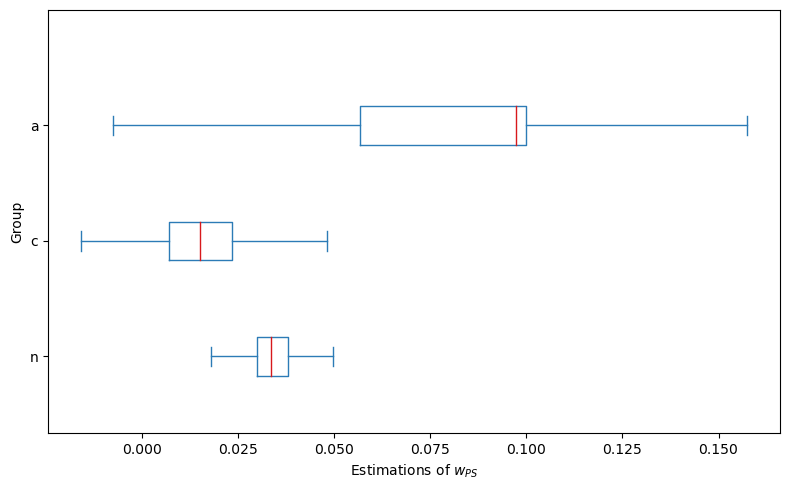

0.034747597 0.007269731
0.016124899 0.011151836
0.07713666 0.03133417


In [51]:
to_load = "NN_results/PS_"
xlabel = r"Estimations of $w_{PS}$"
save_name = "groups_NN_w_ps.pdf"
save_name = ""

groups = ["n", "c", "a"]
trials1 = []

for group in groups:
    trial1 = np.load(to_load + group + str(1) + '_1.npy')
    trial1 = np.concatenate((trial1, np.load(to_load + group + str(1) + '_2.npy')))
    trial1 = np.concatenate((trial1, np.load(to_load + group + str(1) + '_3.npy')))
    for i in range(4):
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_1.npy')))
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_2.npy')))
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_3.npy')))
    trials1.append(trial1)

print(np.mean(trials1[1]))
ticks = [1, 2, 3]
box_plot(trials1, ticks, groups, ylabel = "Group", xlabel=xlabel, save=save_name)

print(np.mean(trials1[0]), np.std(trials1[0]))
print(np.mean(trials1[1]), np.std(trials1[1]))
print(np.mean(trials1[2]), np.std(trials1[2]))

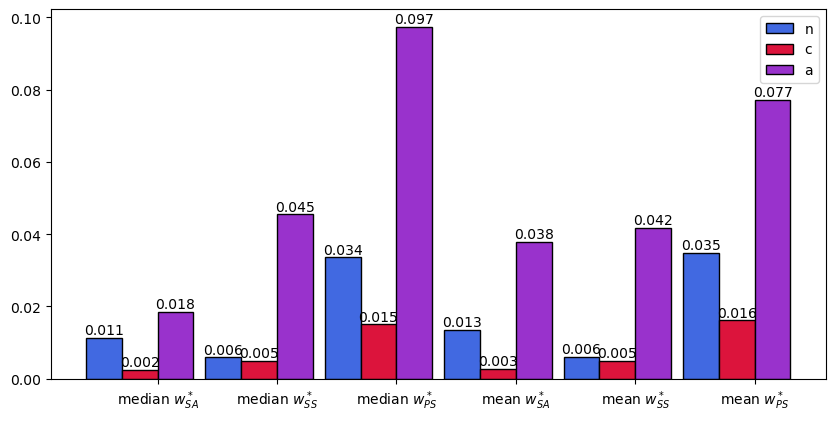

In [112]:
loaders = ["NN_results/SA_", "NN_results/SS_", "NN_results/PS_"]
groups = ["n", "c", "a"]

median_SA = []
median_PS = []
median_SS = []

mean_SA = []
mean_PS = []
mean_SS = []


for to_load in loaders:
    for group in groups:
        trial1 = np.load(to_load + group + str(1) + '_1.npy')
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(1) + '_2.npy')))
        trial1 = np.concatenate((trial1, np.load(to_load + group + str(1) + '_3.npy')))
        for i in range(4):
            trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_1.npy')))
            trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_2.npy')))
            trial1 = np.concatenate((trial1, np.load(to_load + group + str(i+2) + '_3.npy')))

        if to_load == "NN_results/SA_":
            median_SA.append(np.median(trial1))
            mean_SA.append(np.mean(trial1))
        if to_load == "NN_results/SS_":
            median_SS.append(np.median(trial1))
            mean_SS.append(np.mean(trial1))
        if to_load == "NN_results/PS_":
            median_PS.append(np.median(trial1))
            mean_PS.append(np.mean(trial1))


data = [np.array(median_SA), np.array(median_SS), np.array(median_PS), np.array(mean_SA), np.array(mean_SS), np.array(mean_PS)]
bar_plot(np.array(data), save="NN_bar_plot_results.pdf")



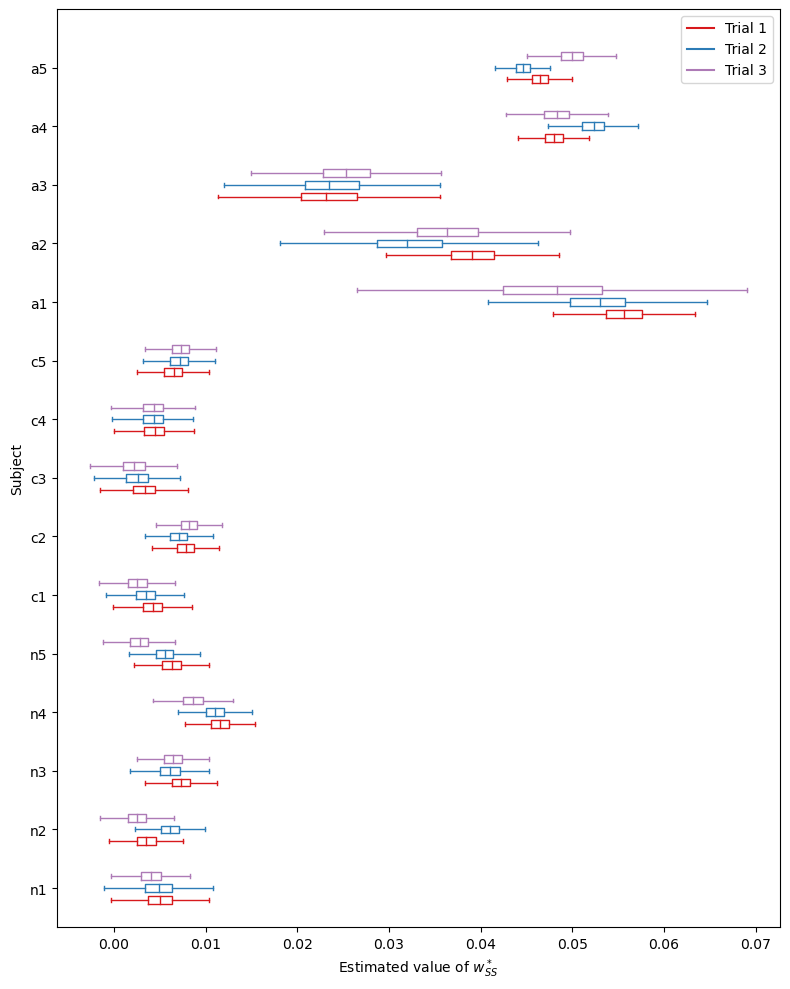

In [12]:
to_load = "NN_results/SS_"
xlabel = r"Estimated value of $w_{SS}^*$"

groups = ["n", "c", "a"]
trials1 = []
trials2 = []
trials3 = []

for group in groups:
    for i in range(5):
        trial = np.load(to_load + group + str(i+1) + '_1.npy')
        trials1.append(trial)
        trial = np.load(to_load + group + str(i+1) + '_2.npy')
        trials2.append(trial)
        trial = np.load(to_load + group + str(i+1) + '_3.npy')
        trials3.append(trial)

labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"]

box_plot_three(trials1, trials2, trials3, labels, height=10, xlabel=xlabel, save="nn_all_trials_SS.pdf")

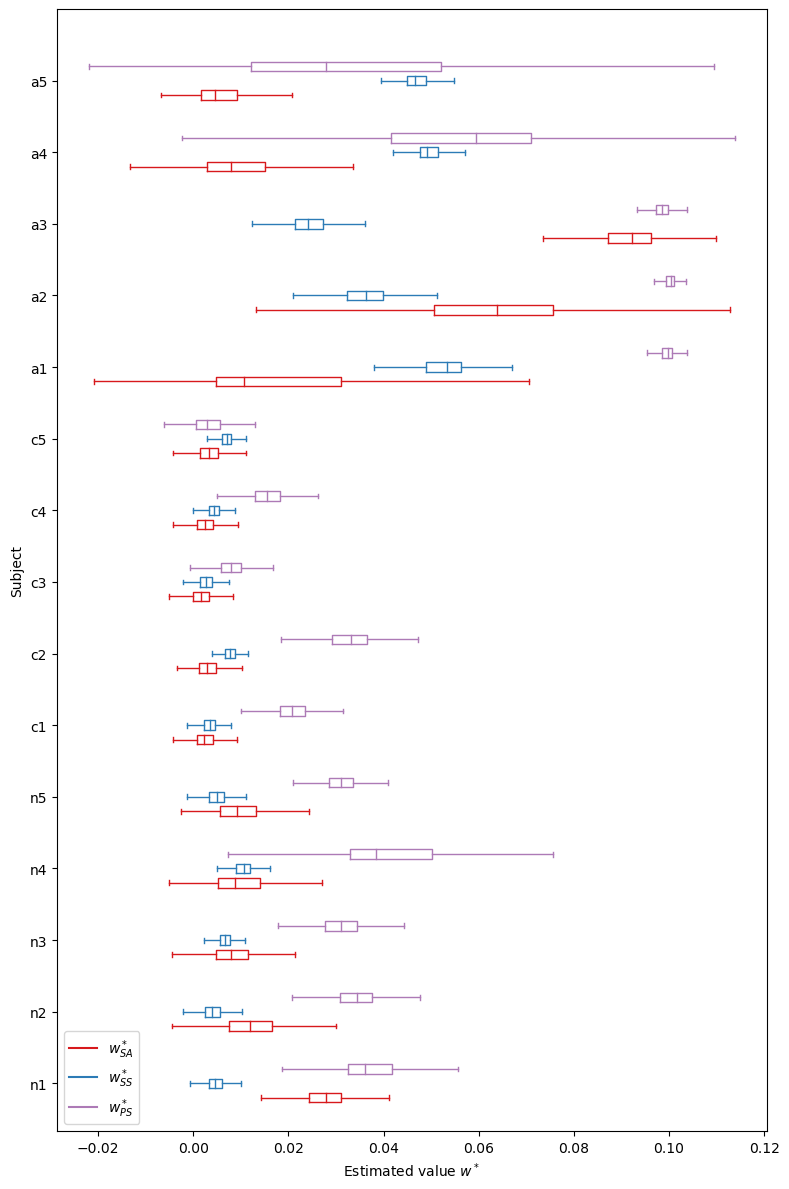

In [25]:
groups = ["n", "c", "a"]
trials1 = []
trials2 = []
trials3 = []

for group in groups:
    for i in range(5):
        trial1 = np.load('NN_results/SA_' + group + str(i+1) + '_1.npy')
        trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(i+1) + '_2.npy')))
        trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(i+1) + '_3.npy')))
        
        trial2 = np.load('NN_results/SS_' + group + str(i+1) + '_1.npy')
        trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(i+1) + '_2.npy')))
        trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(i+1) + '_3.npy')))
        
        trial3 = np.load('NN_results/PS_' + group + str(i+1) + '_1.npy')
        trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(i+1) + '_2.npy')))
        trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(i+1) + '_3.npy')))
        trials1.append(trial1)
        trials2.append(trial2)
        trials3.append(trial3)


labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"]
box_plot_three(trials1, trials2, trials3, labels, labels = [r"$w_{SA}^*$", r"$w_{SS}^*$", r"$w_{PS}^*$"], height=12)

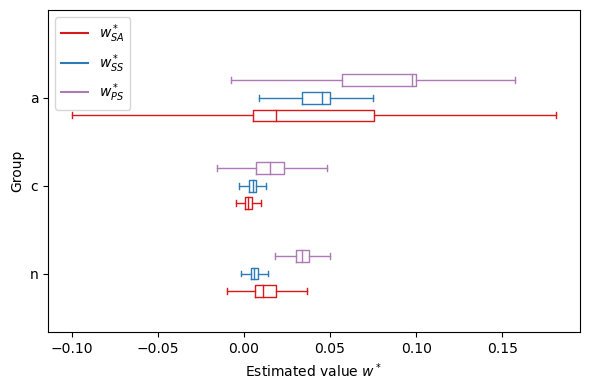

In [21]:
groups = ["n", "c", "a"]
trials1 = []
trials2 = []
trials3 = []

for group in groups:
    trial1 = np.load('NN_results/SA_' + group + str(1) + '_1.npy')
    trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(1) + '_2.npy')))
    trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(1) + '_3.npy')))
    trial2 = np.load('NN_results/SS_' + group + str(1) + '_1.npy')
    trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(1) + '_2.npy')))
    trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(1) + '_3.npy')))
    trial3 = np.load('NN_results/PS_' + group + str(1) + '_1.npy')
    trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(1) + '_2.npy')))
    trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(1) + '_3.npy')))
    for i in range(4):
        trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(i+2) + '_1.npy')))
        trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(i+2) + '_2.npy')))
        trial1 = np.concatenate((trial1, np.load('NN_results/SA_' + group + str(i+2) + '_3.npy')))
        trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(i+2) + '_1.npy')))
        trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(i+2) + '_2.npy')))
        trial2 = np.concatenate((trial2, np.load('NN_results/SS_' + group + str(i+2) + '_3.npy')))
        trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(i+2) + '_1.npy')))
        trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(i+2) + '_2.npy')))
        trial3 = np.concatenate((trial3, np.load('NN_results/PS_' + group + str(i+2) + '_3.npy')))
    trials1.append(trial1)
    trials2.append(trial2)
    trials3.append(trial3)



box_plot_three(trials1, trials2, trials3, groups, labels = [r"$w_{SA}^*$", r"$w_{SS}^*$", r"$w_{PS}^*$"], ylabel="Group", width=6)

## Results assessment
This section compares signals generated with the Ivanov model with the parameter estimation of each subjects with the actual heart rate signal of that subject

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

import sys
sys.path.append('../')
import FractalModels as fm
import FractalAnalysis as fa

In [17]:
def get_beats(subject, abnormal=False):
    """
    Get the heart rate data for a given subject

    Arguments:
    - subject:  ID of the subject to get the heart rate. Must be of the format
                "group" + "number" + "nn". Where group is n (healthy), c 
                (congestive heart failure) or a (atrial fibrillation) and the
                number is between 1 and 5.
    - abnormal: True to print the proportion of abnormal beats (i.e. noisy 
                data), False otherwise

    Returns:
    - A numpy array with the heart rate (interbeats) signal
    """
    with open('../Heart-rates-disease/' + subject + '.txt') as f:
        lines = f.readlines()

    beats = []
    
    count_abnormal = 0
    count = 0

    for line in lines:
        line = line.split()
        if line[1] != "N":
            count_abnormal += 1
        beats.append(float(line[0]))
        count += 1
    
    if abnormal:
        print("Abnormal beats: ", count_abnormal/count*100, "%")
    return np.asarray(beats)  

### Visual aspect

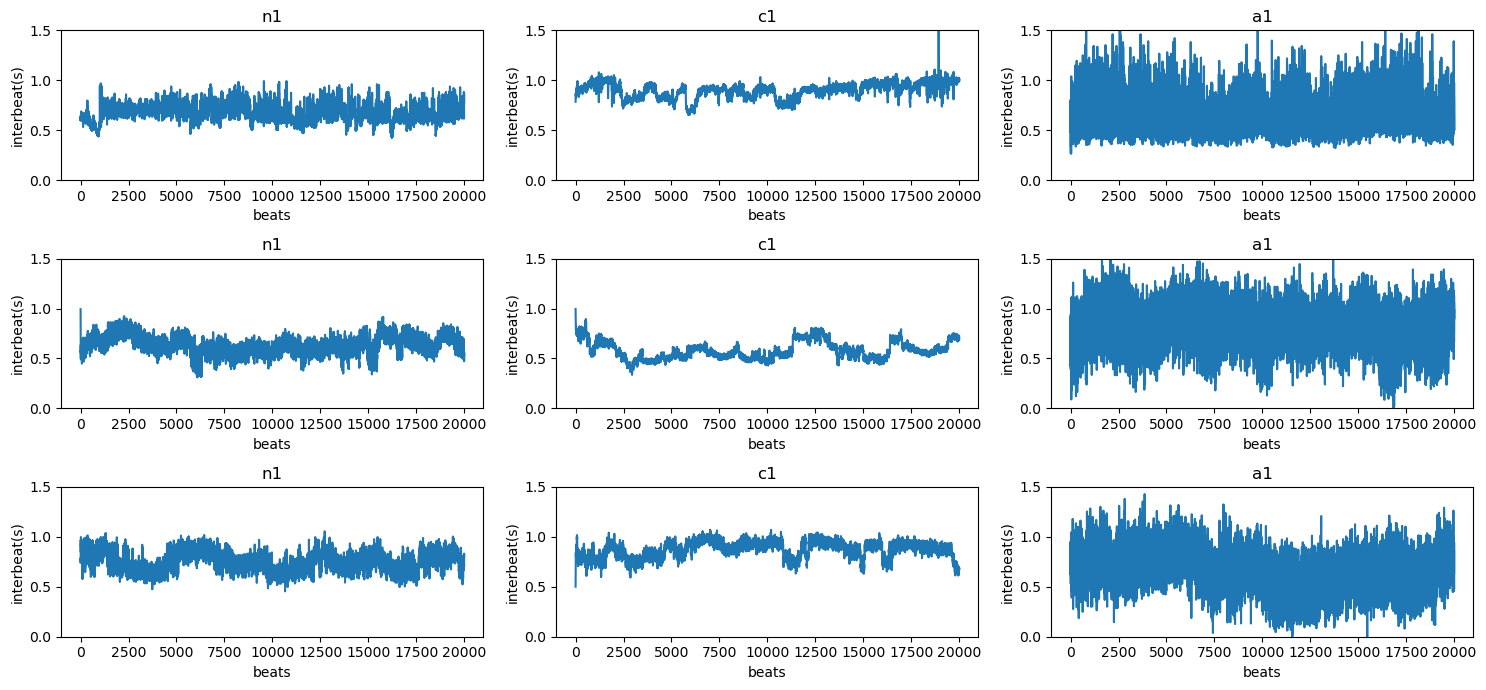

In [54]:
subject = 1

trial1 = np.load('ABC_results/n' + str(subject) + 'nn.npy')
trial2 = np.load('ABC_results/c' + str(subject) + 'nn.npy')
trial3 = np.load('ABC_results/a' + str(subject) + 'nn.npy')


def subplots(x, title):
    plt.plot(x)
    plt.ylim(0, 1.5)
    plt.xlabel("beats")
    plt.ylabel("interbeat(s)")
    plt.title(title)


#defining figure layout (i.e. rows, columns, size, horizontal and vertical space between subplots
fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(15,7))
plt.subplots_adjust(hspace=0.4,wspace=0.2)

#first subplot (numbering can be read as 1st plot in a grid of 2x2)
plt.subplot(3,3,1)
x = get_beats("n" + str(subject) + "nn")
subplots(x[0:20000], "n" + str(subject))

#second subplot in a grid of 2x2
plt.subplot(3,3,2)
x = get_beats("c" + str(subject) + "nn")
subplots(x[0:20000], "c" + str(subject))

#third subplot in a grid of 2x2
plt.subplot(3,3,3)
x = get_beats("a" + str(subject) + "nn")
subplots(x[0:20000], "a" + str(subject))

#fourth subplot in a grid of 2x2
plt.subplot(3,3,4)
x = fm.IvanovModel(w_SS=np.mean(trial1), w_PS=0, w_SA=0, N=10)
subplots(x, "n" + str(subject))

#fourth subplot in a grid of 2x2
plt.subplot(3,3,5)
x = fm.IvanovModel(w_SS=np.mean(trial2), w_PS=0, w_SA=0, N=10)
subplots(x, "c" + str(subject))

#fourth subplot in a grid of 2x2
plt.subplot(3,3,6)
x = fm.IvanovModel(w_SS=np.mean(trial3), w_PS=0, w_SA=0, N=10, t_SS_higher=1.2, t_SS_lower=0.4)
subplots(x, "a" + str(subject))

trial_SA = np.load("NN_results/SA_n" + str(subject) + '_1.npy')
trial_SS = np.load("NN_results/SS_n" + str(subject) + '_1.npy')
trial_PS = np.load("NN_results/PS_n" + str(subject) + '_1.npy')

#fourth subplot in a grid of 2x2
plt.subplot(3,3,7)
x = fm.IvanovModel(w_SS=np.mean(trial_SS), w_PS=np.mean(trial_PS), w_SA=np.mean(trial_SA), N=7)
subplots(x, "n" + str(subject))

trial_SA = np.load("NN_results/SA_c" + str(subject) + '_1.npy')
trial_SS = np.load("NN_results/SS_c" + str(subject) + '_1.npy')
trial_PS = np.load("NN_results/PS_c" + str(subject) + '_1.npy')

#fourth subplot in a grid of 2x2
plt.subplot(3,3,8)
x = fm.IvanovModel(w_SS=np.mean(trial_SS), w_PS=np.mean(trial_PS), w_SA=np.mean(trial_SA), N=7)
subplots(x, "c" + str(subject))

trial_SA = np.load("NN_results/SA_a" + str(subject) + '_1.npy')
trial_SS = np.load("NN_results/SS_a" + str(subject) + '_1.npy')
trial_PS = np.load("NN_results/PS_a" + str(subject) + '_1.npy')

#fourth subplot in a grid of 2x2
plt.subplot(3,3,9)
x = fm.IvanovModel(w_SS=np.mean(trial_SS), w_PS=np.mean(trial_PS), w_SA=np.mean(trial_SA), N=7)
subplots(x, "a" + str(subject))


plt.tight_layout()
plt.savefig("subjects1_simulations.pdf")
plt.show()

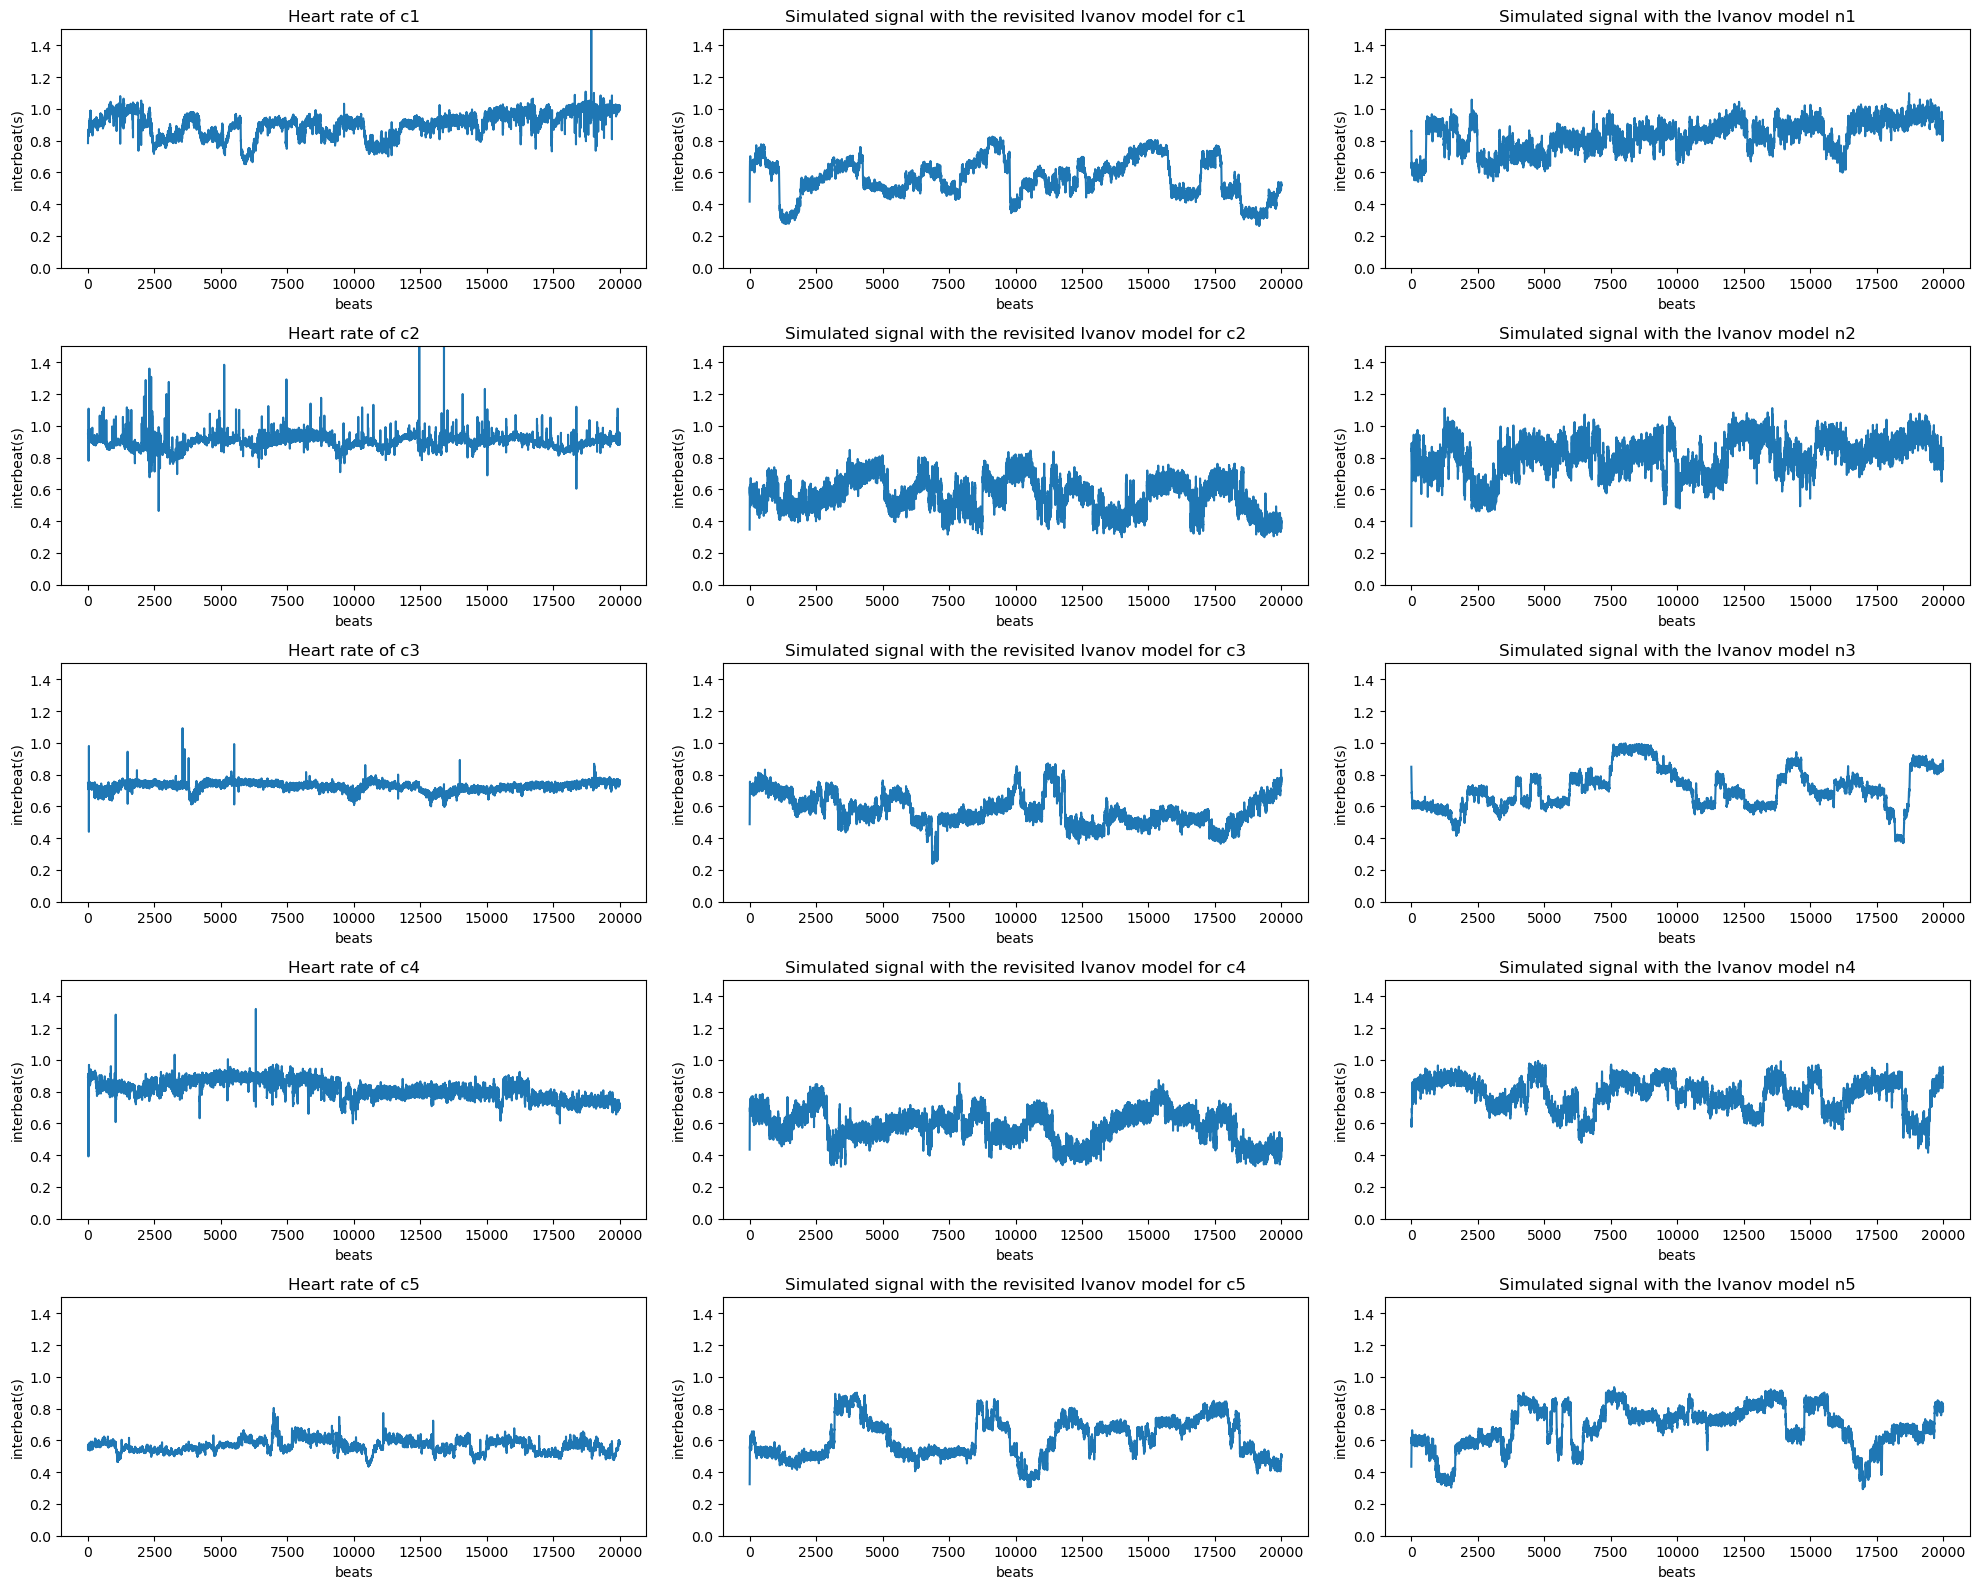

In [29]:
group = "c"

def subplots(x, title):
    plt.plot(x)
    plt.ylim(0, 1.5)
    plt.xlabel("beats")
    plt.ylabel("interbeat(s)")
    plt.title(title)


#defining figure layout (i.e. rows, columns, size, horizontal and vertical space between subplots
fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(20,16))
plt.subplots_adjust(hspace=0.4,wspace=0.2)

for i in range(5):
    plt.subplot(5,3,i*3+1)
    x = get_beats(group + str(i+1) + "nn")
    subplots(x[0:20000], "Heart rate of " + group + str(i+1))

    plt.subplot(5,3,i*3+2)
    trial1 = np.load('ABC_results/' + group + str(i+1) + 'nn.npy')
    x = fm.IvanovModel(w_SS=np.mean(trial1), w_PS=0, w_SA=0, N=10)
    subplots(x, "Simulated signal with the revisited Ivanov model for " + group + str(i+1))

    plt.subplot(5,3,i*3+3)
    trial_SA = np.load("NN_results/SA_" + group + str(i+1) + '_1.npy')
    trial_SS = np.load("NN_results/SS_" + group + str(i+1) + '_1.npy')
    trial_PS = np.load("NN_results/PS_" + group + str(i+1) + '_1.npy')
    x = fm.IvanovModel(w_SS=np.mean(trial_SS), w_PS=np.mean(trial_PS), w_SA=np.mean(trial_SA), N=7)
    subplots(x, "Simulated signal with the Ivanov model n" + str(i+1))

plt.tight_layout()
plt.savefig("subjects_simulations_c.pdf")
plt.show()

### DFA and autocorrelation

In [3]:
def bar_plot(data, save = "", bar_labels = ["Real value", "Mean over 100 trials"], 
             group_labels = ["n1", "n2", "n3", "n4", "n5", "c1", "c2", "c3", "c4", "c5", "a1", "a2", "a3", "a4", "a5"],
             title="", ylabel=""
             ):

      
    # Define colors for the bars
    colors = ["midnightblue", 'orchid', 'crimson', 'darkorchid', 'deepskyblue']

    # Create a figure and axis
    fig, ax = plt.subplots()
    fig.set_figwidth(10)

    # Set the positions of the bars
    positions = np.arange(len(group_labels))

    # Set the width and spacing of the bars
    total_bar_width = 0.9  # Total width for each group (including spacing)
    bar_width = total_bar_width / len(bar_labels)  # Width of each individual bar
    bar_spacing = 0  # Spacing between bars within each group

    # Plot each group of bars
    for i in range(len(bar_labels)):
        bar_positions = positions + i * (bar_width + bar_spacing)
        ax.bar(bar_positions, data[:, i], width=bar_width, color=colors[i % len(colors)], edgecolor='black', label=bar_labels[i])

    # Set the x-axis tick positions and labels
    ax.set_xticks(positions + total_bar_width / 2)
    ax.set_xticklabels(group_labels)

    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Subject")

    if save != "":
        plt.savefig(save)
    # Show the plot
    plt.show()

### ABC

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


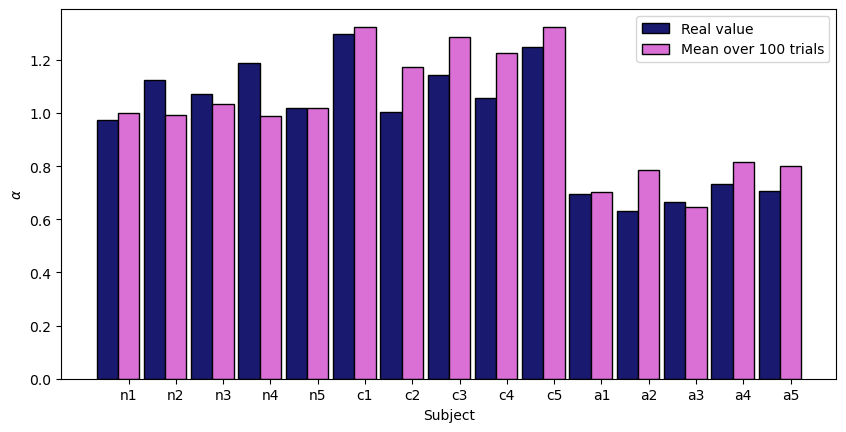

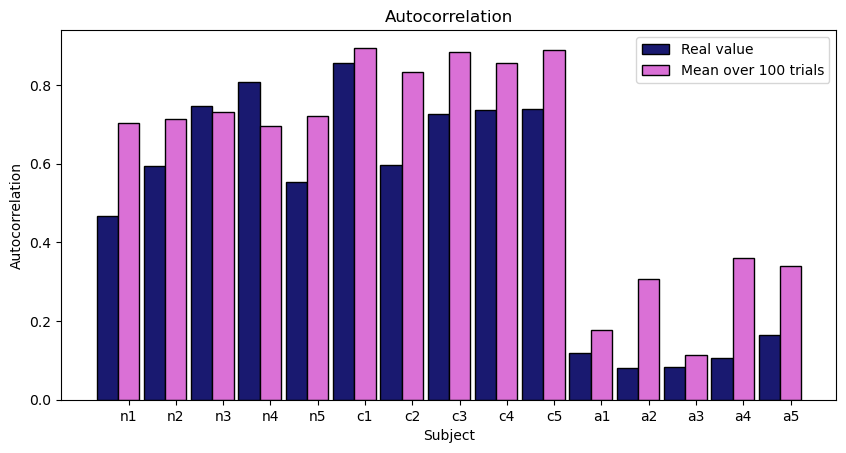

In [6]:
histogram_plot = False
autocorrelation_plot = False
groups = ["n", "c", "a"]

x = np.linspace(np.log(5), np.log(500), 30)
lag = np.exp(x).astype(int)

DFA_plot = []
autocorr_plot = []

for group in groups:
    for i in range(5):
        # Load parameters estimation
        trial1 = np.load("ABC_results/" + group + str(i+1) + 'nn.npy')
        tmp = np.load("ABC_results/"  + group + str(i+1) + '.npy')
        trial1 = np.concatenate((trial1, tmp[0]))
        trial1 = np.concatenate((trial1, tmp[1]))
        trial1 = np.concatenate((trial1, tmp[2]))

        alphas = np.zeros(100)
        autocorr = np.zeros(100)

        for j in tqdm(range(100)):
            # Draw parameter
            w = np.random.choice(trial1, size=1)[0]

            # Generate signal
            sig = fm.IvanovModel(N=10, w_SS=w, w_SA=0, w_PS=0)

            # DFA
            alphas[j] = fa.DFA2(sig, lag)

            # Auto-correlation
            acorr = sm.tsa.acf(sig, nlags = 100)
            acorr = acorr[1:]
            autocorr[j] = np.mean(acorr)

        
        # Plot alphas distribution for each subject
        if histogram_plot:
            plt.hist(alphas)
            plt.title(group + str(i+1))
            plt.show()

        # Plot the autocorrelation of one signal and the original heart rate signal
        if autocorrelation_plot:
            data = fm.IvanovModel(N=10, w_SS=np.mean(trial1), w_SA=0, w_PS=0)
            plot_acf(data, lags=100)
            plt.title(group + str(i+1))
            plt.show()
            beats = get_beats(group + str(i+1) + "nn")
            plot_acf(beats[0:20000], lags=100)
            plt.title(group + str(i+1))
            plt.show()

        # DFA on the original heart rate signal
        beats = get_beats(group + str(i+1) + "nn")
        alpha_beats = fa.DFA2(beats[0:20000], lag)
        DFA_plot.append([alpha_beats, np.mean(alphas)])

        # Auto-correlation on the original heart rate signal
        acorr = sm.tsa.acf(beats[0:20000], nlags = 100)
        acorr = acorr[1:]
        autocorr_plot.append([np.mean(acorr), np.mean(autocorr)])

# Plot results
for i in range(len(DFA_plot)):
    DFA_plot[i] = np.array(DFA_plot[i])
    autocorr_plot[i] = np.array(autocorr_plot[i])

bar_plot(np.array(DFA_plot), ylabel=r"$\alpha$", save="DFA_ABC.pdf")
bar_plot(np.array(autocorr_plot), title="Autocorrelation", ylabel="Autocorrelation")
        

### Neural networks

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


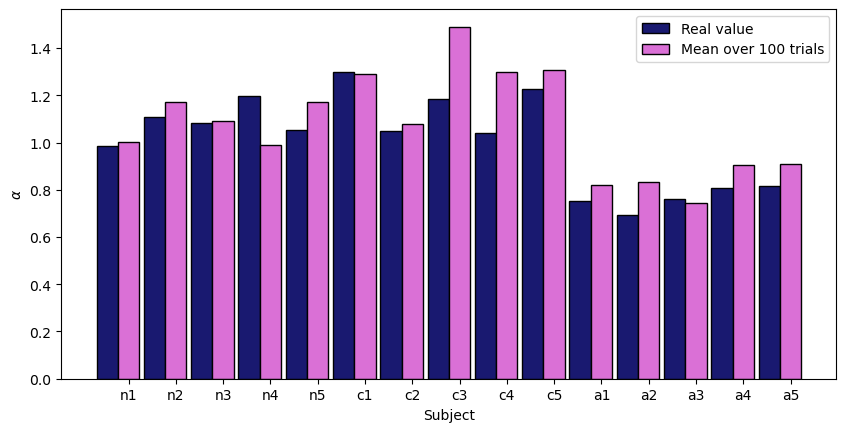

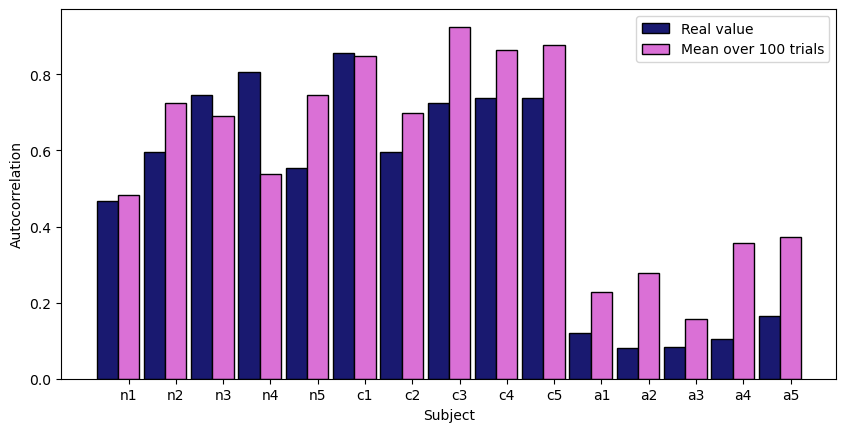

In [7]:
histogram_plot = False
groups = ["n", "c", "a"]
to_load = "NN_results/PS_"

DFA_plot = []
autocorr_plot = []

for group in groups:
    for i in range(5):
        # Load parameters estimation
        trial_SA = np.load("NN_results/SA_" + group + str(i+1) + '_1.npy')
        trial_SA = np.concatenate((trial1, np.load("NN_results/SA_" + group + str(i+1) + '_2.npy')))
        trial_SA = np.concatenate((trial1, np.load("NN_results/SA_" + group + str(i+1) + '_3.npy')))

        trial_SS = np.load("NN_results/SS_" + group + str(i+1) + '_1.npy')
        trial_SS = np.concatenate((trial1, np.load("NN_results/SS_" + group + str(i+1) + '_2.npy')))
        trial_SS = np.concatenate((trial1, np.load("NN_results/SS_" + group + str(i+1) + '_3.npy')))

        trial_PS = np.load("NN_results/PS_" + group + str(i+1) + '_1.npy')
        trial_PS = np.concatenate((trial1, np.load("NN_results/PS_" + group + str(i+1) + '_2.npy')))
        trial_PS = np.concatenate((trial1, np.load("NN_results/PS_" + group + str(i+1) + '_3.npy')))

        alphas = np.zeros(100)
        autocorr = np.zeros(100)

        for j in tqdm(range(100)):
            # Draw the parameters
            w_SA = np.random.choice(trial_SA, size=1)[0]
            w_PS = np.random.choice(trial_PS, size=1)[0]
            w_SS = np.random.choice(trial_SS, size=1)[0]

            # Generate signal
            sig = fm.IvanovModel(N=7, w_SS=w_SS, w_SA=w_SA, w_PS=w_PS)

            # DFA
            x = np.linspace(np.log(5), np.log(1000), 30)
            lag = np.exp(x).astype(int)
            alphas[j] = fa.DFA2(sig, lag)

            # Auto-correlation
            acorr = sm.tsa.acf(sig, nlags = 100)
            acorr = acorr[1:]
            autocorr[j] = np.mean(acorr)

        
        # Plot alphas distribution for each subjects
        if histogram_plot:
            plt.hist(alphas)
            plt.title(group + str(i+1))
            plt.show()

            data = fm.IvanovModel(N=10, w_SS=np.mean(trial1), w_SA=0, w_PS=0)
            plot_acf(data, lags=100)
            plt.title(group + str(i+1))
            plt.show()

        # DFA on the original heart rate signal
        beats = get_beats(group + str(i+1) + "nn")
        alpha_beats = fa.DFA2(beats[0:20000], lag)
        DFA_plot.append([alpha_beats, np.mean(alphas)])

        acorr = sm.tsa.acf(beats[0:20000], nlags = 100)
        acorr = acorr[1:]
        autocorr_plot.append([np.mean(acorr), np.mean(autocorr)])

# Plot
for i in range(len(DFA_plot)):
    DFA_plot[i] = np.array(DFA_plot[i])
    autocorr_plot[i] = np.array(autocorr_plot[i])

bar_plot(np.array(DFA_plot), ylabel=r"$\alpha$", save="DFA_NN.pdf")
bar_plot(np.array(autocorr_plot), ylabel="Autocorrelation")